## Урок 3. Домашнее задание

In [245]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

Для начала скопируем необходимую предобработку данных из лекции.

In [246]:
df = pd.read_csv('./lection3_materials/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [247]:
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

Разделение данных на тренировочную и тестовую выборки.

In [248]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

Создание пайплайнов для разных типов переменных (скопировано из лекции без изменений).

In [249]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]



continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))
    
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

Воспользуемся кросс-валидацией для оценки качества работы построенной модели.

In [250]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score для данной модели.

In [251]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем ROC-AUC кривую.

In [252]:
def roc_auc_graph(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    
    return None

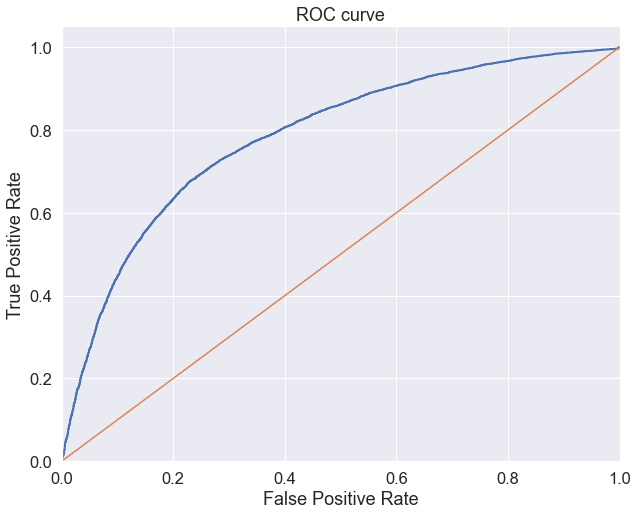

In [253]:
roc_auc_graph(y_test, y_score)

In [254]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668


Построим матрицу ошибок.

In [255]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Будем выводить тип матрицы только в заголовке и округлять нормализованные значения
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 6)
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix'
        

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Уберем сетку
    plt.grid(False)
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

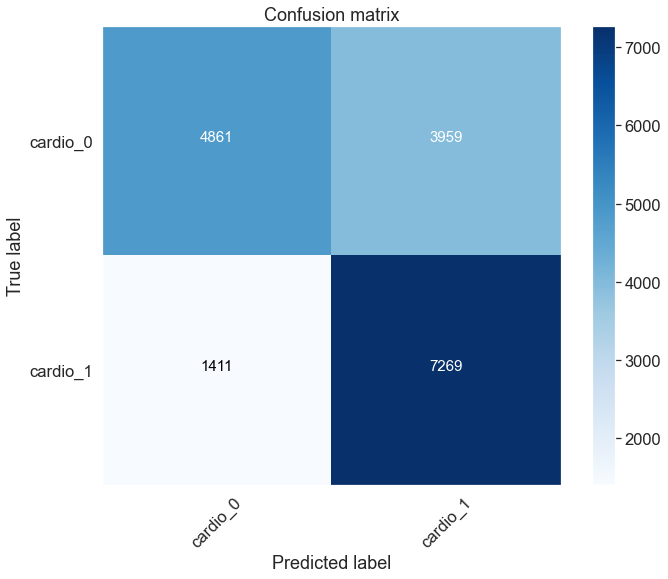

In [256]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.show()

## Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию

Модель логистической регрессии была обучена на лекции (скопирована выше). Обучим дополнительно случайный лес и стохастический градиентный бустинг.

In [257]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Для деревьев важность предобработки данных (в частности нормализация числовых признаков и One Hot Encoding) 
# не так велика, поэтому опустим этот этап в пайплайне


classifier_rf = Pipeline([
#     ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

classifier_gb = Pipeline([
#     ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

Начнем со случайного леса.

In [258]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_rf, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7867706416947285+-0.00859863014690675


Посчитаем precision/recall/f_score для данной модели.

In [259]:
b=1
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_rf)
fscore_rf = (1+b**2)*(precision_rf * recall_rf) / (b**2*precision_rf + recall_rf)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

Best Threshold=0.340000, F-Score=0.728, Precision=0.643, Recall=0.840


Нарисуем ROC-AUC кривую.

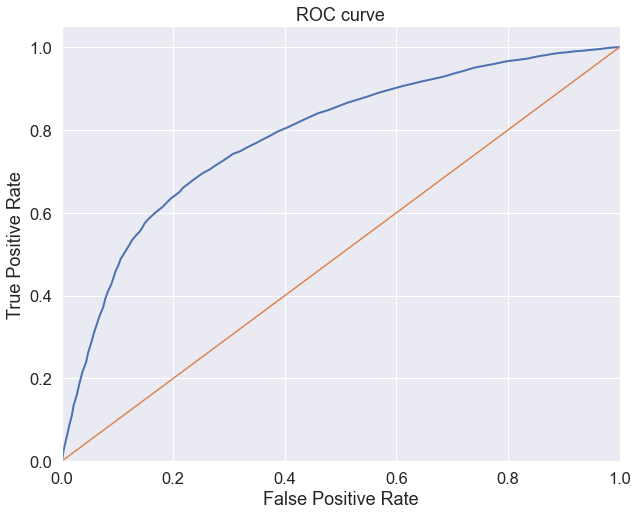

In [260]:
roc_auc_graph(y_test, y_score_rf)

In [261]:
print(f"roc auc score: {roc_auc_score(y_test, y_score_rf)}")
print(f"log loss score: {log_loss(y_test, y_score_rf)}")

roc auc score: 0.7843040403565419
log loss score: 0.5650729803317743


Построим матрицу ошибок.

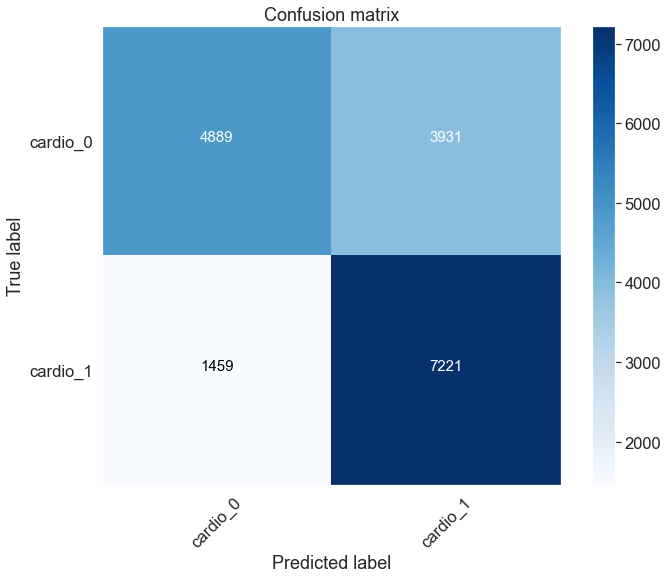

In [262]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, y_score_rf>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['cardio_0', 'cardio_1'])
plt.show()

Теперь проведем аналогичные вычисления для модели стохастического градиентного бустинга.

In [263]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gb, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_gb.fit(X_train, y_train)
y_score_gb = classifier_gb.predict_proba(X_test)[:, 1]

CV score is 0.8023350786053844+-0.007012956829593749


Посчитаем precision/recall/f_score для данной модели.

In [264]:
b=1
eps=1e-15
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test.values, y_score_gb)
# Заменим нулевые значения в precision_gb и recall_gb на очень маленькие, 
# но отличные от нуля значения eps, для удобства вычислений fscore, чтобы не получать ошибки при делении на ноль

precision_gb[precision_gb == 0] = eps
recall_gb[recall_gb == 0] = eps

fscore_gb = (1+b**2)*(precision_gb * recall_gb) / (b**2*precision_gb + recall_gb)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

Best Threshold=0.358828, F-Score=0.740, Precision=0.671, Recall=0.825


Нарисуем ROC-AUC кривую.

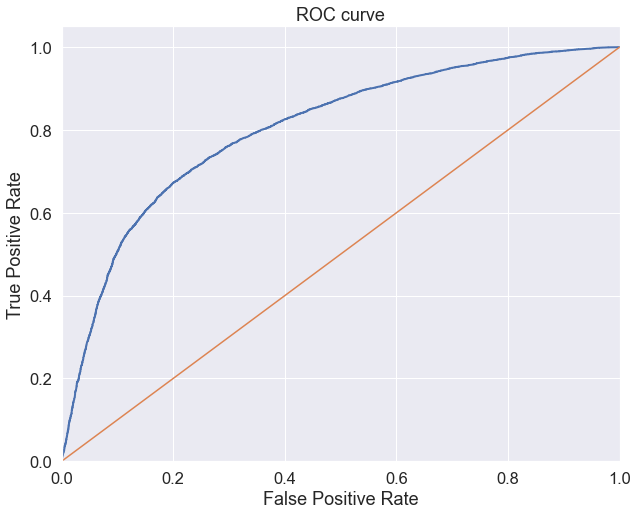

In [265]:
roc_auc_graph(y_test, y_score_gb)

In [266]:
print(f"roc auc score: {roc_auc_score(y_test, y_score_gb)}")
print(f"log loss score: {log_loss(y_test, y_score_gb)}")

roc auc score: 0.8024075140809013
log loss score: 0.5400159528789521


Построим матрицу ошибок.

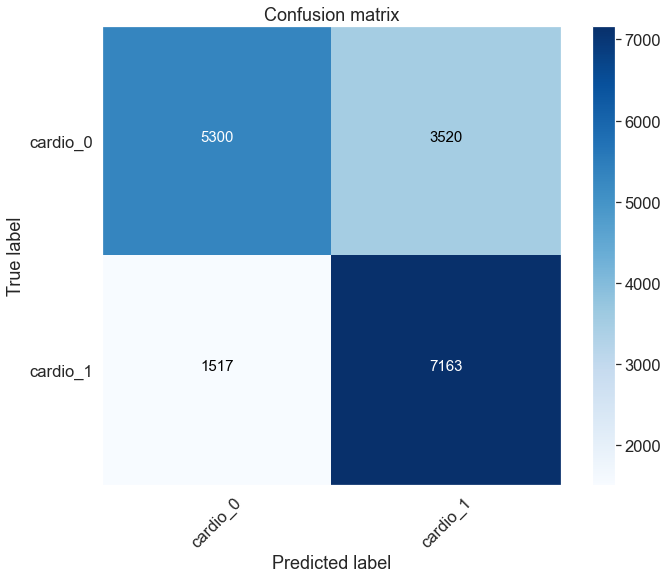

In [267]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, y_score_gb>thresholds_gb[ix_gb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['cardio_0', 'cardio_1'])
plt.show()

3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [268]:
df = pd.DataFrame([['logreg', precision[ix], recall[ix], fscore[ix], roc_auc_score(y_test, y_score), log_loss(y_test, y_score)], 
                   ['rf', precision_rf[ix_rf], recall_rf[ix_rf], fscore_rf[ix_rf], roc_auc_score(y_test, y_score_rf), log_loss(y_test, y_score_rf)], 
                   ['gb', precision_gb[ix_gb], recall_gb[ix_gb], fscore_gb[ix_gb], roc_auc_score(y_test, y_score_gb), log_loss(y_test, y_score_gb)]], 
                   columns=['method', 'precision', 'recall', 'fscore', 'roc_auc', 'log_loss'])
df

,method,precision,recall,fscore,roc_auc,log_loss
0,logreg,0.647431,0.837558,0.730323,0.784035,0.577960
1,rf,0.642756,0.840323,0.728380,0.784304,0.565073
2,gb,0.670535,0.825346,0.739930,0.802408,0.540016


4. сделать выводы о том, какая модель справилась с задачей лучше других

По большинству метрик лучшей оказывается модель стохастического градиентного бустинга, лишь по показателю `Recall` лучше остальных себя показывает модель случайного леса.

5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).


p.s. В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90


Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

В случае сильного дисбаланса классов лучше принимать решения на основе графика `precision_recall_curve`, так как он строится на основе показателей `Precision` и `Recall`, которые вместе хорошо отражают способность модели классифицировать объекты. В свою очередь кривая ROC строится на основе `FPR` и `Recall`, что может быть проблемой в случае несбалансированных данных. 


В примере, приведенном в задании, для первой модели получаются следующие значения метрик: `Recall` = 0.9; `Precision` = 0.9; `FPR` = 0.0001. Для второй модели будут следующие значения: `Recall` = 0.9; `Precision` = 0.09; `FPR` = 0.0091. Исходя из общих соображений очевидно, что вторая модель хуже первой, это особенно хорошо видно на примере падения метрики `Precision`, которая используется при построении графика `precision_recall_curve`. В свою очередь показатель `FPR`, который используется при построении `roc_auc_curve`, хоть и вырос, но все равно остается очень маленьким, что может указывать на достаточно хорошее качество модели. Это происходит из-за того, что в знаменателе `FPR` фигурирует общее количество элементов негативного класса (представителей которого при несбалансированной выборке обычно значительно больше, чем элементов позитивного класса).

Посмотрим площадь под кривой `precision_recall_curve` для разных моделей в нашей задаче.

In [269]:
from sklearn.metrics import auc

auc_pr_logreg = auc(recall, precision)
auc_pr_rf = auc(recall_rf, precision_rf)
auc_pr_gb = auc(recall_gb, precision_gb)

df_auc = pd.DataFrame([[auc_pr_logreg], [auc_pr_rf], [auc_pr_gb]], columns=['pr_auc'])
pd.concat([df, df_auc], axis=1)

,method,precision,recall,fscore,roc_auc,log_loss,pr_auc
0,logreg,0.647431,0.837558,0.730323,0.784035,0.577960,0.763165
1,rf,0.642756,0.840323,0.728380,0.784304,0.565073,0.765184
2,gb,0.670535,0.825346,0.739930,0.802408,0.540016,0.782215


Как видим, по этому показателю модель стохастического градиентного бустинга также оказывается лучшей из представленных. Вывод не поменялся в том числе, потому что наш датасет не страдает от проблемы несбалансированности классов.